# Initialization and support code

In [1]:
# Copyright (C) 2021 by Joni Hyttinen <joni.hyttinen@uef.fi>
#                       Pauli Fält <pauli.falt@uef.fi>
#
# Permission to use, copy, modify, and/or distribute this software for any
# purpose with or without fee is hereby granted.
#
# THE SOFTWARE IS PROVIDED "AS IS" AND THE AUTHOR DISCLAIMS ALL WARRANTIES WITH
# REGARD TO THIS SOFTWARE INCLUDING ALL IMPLIED WARRANTIES OF MERCHANTABILITY
# AND FITNESS. IN NO EVENT SHALL THE AUTHOR BE LIABLE FOR ANY SPECIAL, DIRECT,
# INDIRECT, OR CONSEQUENTIAL DAMAGES OR ANY DAMAGES WHATSOEVER RESULTING FROM
# LOSS OF USE, DATA OR PROFITS, WHETHER IN AN ACTION OF CONTRACT, NEGLIGENCE OR
# OTHER TORTIOUS ACTION, ARISING OUT OF OR IN CONNECTION WITH THE USE OR
# PERFORMANCE OF THIS SOFTWARE.
#

# BIG section of supporting code we don't need to touch in detail
# from google.colab import drive

from pathlib import Path
import warnings

import matplotlib.pyplot as plt
import numpy as np
from skimage.exposure import histogram, rescale_intensity
from skimage.util import invert
from tifffile import TiffFile

# Initialize the workspace
# Collect all spectral images available to us
from asi import path_config

_root = path_config.lectures
spim_base_path = _root / ("LectureExercise #10, PCA/Data/")
spim_files = {
    x.stem: {"spim": x} for x in spim_base_path.glob("*.tif") if not x.stem.endswith("_masks")
}
mask_files = {
    x.stem[: -len("_masks")]: x for x in spim_base_path.glob("*.tif") if x.stem.endswith("_masks")
}
for mask_stem, mask_file in mask_files.items():
    if mask_stem in spim_files:
        spim_files[mask_stem]["mask"] = mask_file
spim_files_with_masks = {k: v for k, v in spim_files.items() if "mask" in v}

if spim_files_with_masks:
    print("*** Found following spectral images and their masks:")
    for entry in spim_files_with_masks:
        print(f"    {entry}")
else:
    print("!!! Found no spectral images with masks")


def read_stiff(filename: str, silent=False, rgb_only=False):
    """Load spectral image cubes saved as TIFF-images.

    :param filename:    filename of the spectral tiff to read.
    :return:            Tuple[spim, wavelengths, rgb, metadata], where
                        spim: spectral image cube of form [height, width, bands],
                        wavelengths: the center wavelengths of the bands,
                        rgb: a color render of the spectral image [height, width, channels] or None
                        metadata: a free-form metadata string stored in the image, or an empty string
    """

    TIFFTAG_WAVELENGTHS = 65000
    TIFFTAG_METADATA = 65111
    spim = None
    wavelengths = None
    rgb = None
    metadata = None

    first_band_page = 0
    with TiffFile(filename) as tiff:
        # The RGB image is optional, the first band image maybe on the first page:
        first_band_page = 0
        if tiff.pages[first_band_page].ndim == 3:
            rgb = tiff.pages[0].asarray()
            # Ok, the first band image is on the second page
            first_band_page += 1

        multiple_wavelength_lists = False
        multiple_metadata_fields = False
        for band_page in range(first_band_page, len(tiff.pages)):
            # The wavelength list is supposed to be on the first band image.
            # The older write_tiff writes it on all pages, though, so make
            # a note of it.
            tag = tiff.pages[band_page].tags.get(TIFFTAG_WAVELENGTHS)
            tag_value = tag.value if tag else tuple()
            if tag_value:
                if wavelengths is None:
                    wavelengths = tag_value
                elif wavelengths == tag_value:
                    multiple_wavelength_lists = True
                elif wavelengths != tag_value:
                    # Well, the image is just broken then?
                    msg = f'Spectral-Tiff "{filename}" contains multiple differing wavelength lists!'
                    raise RuntimeError(
                        msg
                    )

            # The metadata string, like the wavelength list, is supposed to be
            # on the first band image. The older write_tiff wrote it on all
            # pages, too. Make a note of it.
            tag = tiff.pages[band_page].tags.get(TIFFTAG_METADATA)
            tag_value = tag.value if tag else ""
            if tag_value:
                if metadata is None:
                    metadata = tag_value
                elif metadata == tag_value:
                    multiple_metadata_fields = True
                elif metadata != tag_value:
                    # Well, for some reason there are multiple metadata fields
                    # with varying content. This version of the function does
                    # not care for such fancyness.
                    msg = f'Spectral-Tiff "{filename}" contains multiple differing metadata fields!'
                    raise RuntimeError(
                        msg
                    )

        # The metadata is stored in an ASCII string. It may contain back-slashed
        # hex sequences (unicode codepoints presented as ASCII text). Convert
        # ASCII string back to bytes and decode as unicode sequence.
        if metadata:
            metadata = metadata.encode("ascii").decode("unicode-escape")
        else:
            metadata = ""

        # Some of the early images may have errorneus metadata string.
        # Attempt to fix it:
        if metadata[0] == "'" and metadata[-1] == "'":
            while metadata[0] == "'":
                metadata = metadata[1:]
            while metadata[-1] == "'":
                metadata = metadata[:-1]
            if "\\n" in metadata:
                metadata = metadata.replace("\\n", "\n")

        # Generate a fake wavelength list, if the spectral tiff has managed to
        # lose its own wavelength list.
        if not wavelengths:
            wavelengths = range(0, len(tiff.pages) - 1 if rgb is not None else len(tiff.pages))

        if multiple_wavelength_lists and not silent:
            warnings.warn(f'Spectral-Tiff "{filename}" contains duplicated wavelength lists!')
        if multiple_metadata_fields and not silent:
            warnings.warn(f'Spectral-Tiff "{filename}" contains duplicated metadata fields!')

        if not rgb_only:
            spim = tiff.asarray(key=range(first_band_page, len(tiff.pages)))
            spim = np.transpose(spim, (1, 2, 0))
        else:
            spim = None

        # Make sure the wavelengths are in an ascending order:
        if wavelengths[0] > wavelengths[-1]:
            spim = spim[:, :, ::-1] if spim is not None else None
            wavelengths = wavelengths[::-1]

    # Convert uint16 cube back to float32 cube
    if spim is not None and spim.dtype == "uint16":
        spim = spim.astype("float32") / (2**16 - 1)

    return spim, np.array(wavelengths), rgb, metadata


def read_mtiff(filename):
    """
    Read a mask bitmap tiff.

    Mask bitmap tiff contains multiple pages of bitmap masks. The mask label
    is stored in tag 65001 in each page. The mask label is stored as an ASCII
    string that may contain unicode codepoints encoded as ASCII character
    sequences (see unicode-escape encoding in Python docs).

    :param filename:    filename of the mask tiff to read.
    :return:            Dict[label: str, mask: ndarray], where
                        label: the mask label
                        mask: the boolean bitmap associated with the label.
    """

    TIFFTAG_MASK_LABEL = 65001
    masks = {}
    with TiffFile(filename) as tiff:
        for p in range(0, len(tiff.pages)):
            label_tag = tiff.pages[p].tags.get(TIFFTAG_MASK_LABEL)
            label = label_tag.value.encode("ascii").decode("unicode-escape")
            mask = tiff.asarray(key=p)
            masks[label] = mask > 0
    return masks


def spim2vec(spim):
    """Vectorize a spectral image cube into a collection of column vectors."""
    from numpy import reshape

    numOfRows, numOfCols, numOfBands = spim.shape

    vec = reshape(spim, (numOfRows * numOfCols, numOfBands))
    vec = vec.T  # spectra on columns

    return vec


def vec2spim(vec, dims):
    """Cubeize a collection of column vectors into a spectral image cube."""
    from numpy import reshape, size

    if size(dims) == 3:
        spim = reshape(vec.T, dims)
    elif size(dims) == 2:
        numOfBands = vec.shape[0]  # spectra must be on columns
        spim = reshape(vec.T, (dims[0], dims[1], numOfBands))
    else:
        print("Error: Not enough dimensions given!")

    return spim


def show_band_images(cube, columns=5):
    """A severe mistake"""
    import matplotlib.pyplot as plt
    import numpy as np

    rows = np.ceil(cube.shape[2] / columns).astype("int")

    i = 0
    for row in range(rows):
        plt.figure(figsize=(20, 5))
        for column in range(columns):
            if i < cube.shape[2]:
                plt.subplot(1, columns, column + 1)
                plt.imshow(cube[:, :, i], cmap="gray")
            i = i + 1

    # plt.figure(figsize=figsize)
    # for i in range(cube.shape[2]):
    #  plt.subplot(cube.shape[2] / columns + 1, columns, i + 1)
    #  plt.imshow(cube[:,:,i], cmap='gray')

*** Found following spectral images and their masks:
    271d63af_front_inpainted_GDBICP_similarity


# Spectral image cube selection

In [2]:
#spim_stem = '5d65db43_bottom_2'
spim_stem = '271d63af_front_inpainted_GDBICP_similarity'
perform_edits = True

spim_file = spim_files_with_masks[spim_stem]['spim']
mask_file = spim_files_with_masks[spim_stem]['mask']

# Some crop parameters for images of interest:
# crop: (start row, end row, start col, end col) or (y1, y2, x1, x2)
#
# Origin (0,0) at the top-left corner, (x_max, y_max) at the bottom-right corner.
image_edit_parameters = {
    '5d65db43_bottom_2': { 'crop': (240, 350, 100, 350)}
}

# Load the cube and its masks
cube, wavelengths, color_image, metadata = read_stiff(spim_file)
masks = read_mtiff(mask_file)

# Edit the images, if parameters have been given for this image
if perform_edits and spim_stem in image_edit_parameters:
  if 'crop' in image_edit_parameters[spim_stem]:
    row_start, row_end, col_start, col_end = image_edit_parameters[spim_stem]['crop']
    cube = cube[row_start:row_end, col_start:col_end, :]
    color_image = color_image[row_start:row_end, col_start:col_end, :]

    for mask_name, mask_image in masks.items():
      masks[mask_name] = mask_image[row_start:row_end, col_start:col_end]

print(f'Loaded spectral image {spim_stem}, shape {cube.shape}')


Loaded spectral image 271d63af_front_inpainted_GDBICP_similarity, shape (1040, 1392, 51)


# Principal component analysis, Part I

Cube of shape (1040, 1392, 51) reshaped into vector (51, 1447680)
Principal vectors: (51, 51)
Explained variances: [1.58394040e-05 1.64761441e-05 1.77583407e-05 1.86230177e-05
 1.89704306e-05 1.98848045e-05 2.16421684e-05 2.34222453e-05
 2.40086318e-05 2.52529334e-05 2.64482735e-05 2.76023949e-05
 2.89823573e-05 3.05057042e-05 3.14983950e-05 3.28453696e-05
 3.50206930e-05 3.61611887e-05 3.69334195e-05 3.72634306e-05
 3.89732298e-05 4.12360160e-05 4.31544643e-05 4.45667276e-05
 4.56253165e-05 4.90817005e-05 5.07986681e-05 5.36061315e-05
 5.54342628e-05 5.96074057e-05 6.61234145e-05 7.09035347e-05
 7.72868680e-05 8.04549889e-05 9.83671478e-05 1.09975678e-04
 1.14475415e-04 1.53406100e-04 1.89384295e-04 2.22387055e-04
 2.70303068e-04 3.40327481e-04 4.12698168e-04 4.84127212e-04
 7.75717121e-04 1.02998936e-03 1.40392453e-03 2.71919566e-03
 7.45121926e-03 3.07590755e-02 9.52163435e-01]
Indices that sort the eigenvectors into order of descending importance
[50 49 48 47 46 45 44 43 42 41 40 3

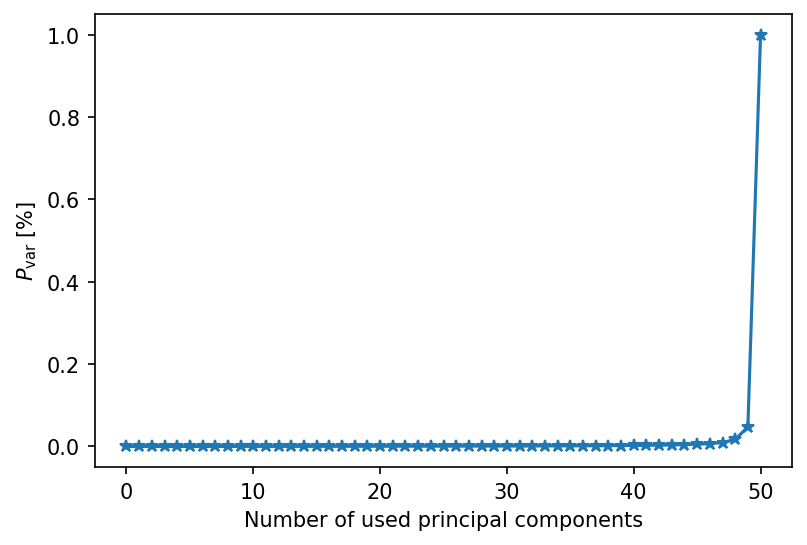

In [4]:
def compute_principal_components(X):
  # Center the input data
  X_mean = X.mean(axis=1)[:, np.newaxis]
  X_centered = X - X_mean

  # Compute the covariance matrix of the centered data
  C = np.cov(X_centered)

  # Compute the eigenvalues and eigenvectors of the covariance matrix
  # NOTE: This function returns (EIGENVALUES, EIGENVECTORS), not
  #       (EIGENVECTORS, EIGENVALUES) like the MATLAB-function referenced in the
  #       lecture slides.
  Lambda, E = np.linalg.eigh(C)

  return E, Lambda, X_mean

# Vectorize the spectral image cube into a collection of spectrum vectors
# by reshaping the cube:
vector = spim2vec(cube)

print(f'Cube of shape {cube.shape} reshaped into vector {vector.shape}')

# Compute the principal components (eigenvectors) and eigenvalues:
pcs, eigenvalues, X_mean = compute_principal_components(vector)

print(f'Principal vectors: {pcs.shape}')

# Compute the explained variance for each principal component
explained_variances = np.array([x / eigenvalues.sum() for x in eigenvalues])
print(f'Explained variances: {explained_variances}')

# Uh oh, np.linalg.eigh() does not guarantee that the eigenvectors and -values
# are in any order!
print('Indices that sort the eigenvectors into order of descending importance')
print(np.flip(np.argsort(explained_variances)))

cumulative_explained_variance = np.cumsum(eigenvalues / eigenvalues.sum())

plt.figure(dpi=150)
plt.plot(np.arange(0, eigenvalues.shape[0]), cumulative_explained_variance, '-*');
plt.xlabel('Number of used principal components');
plt.ylabel('$P_\mathrm{var}$ [%]');


# Principal component analysis, Part II

Explained variances: [9.52163435e-01 3.07590755e-02 7.45121926e-03 2.71919566e-03
 1.40392453e-03 1.02998936e-03 7.75717121e-04 4.84127212e-04
 4.12698168e-04 3.40327481e-04 2.70303068e-04 2.22387055e-04
 1.89384295e-04 1.53406100e-04 1.14475415e-04 1.09975678e-04
 9.83671478e-05 8.04549889e-05 7.72868680e-05 7.09035347e-05
 6.61234145e-05 5.96074057e-05 5.54342628e-05 5.36061315e-05
 5.07986681e-05 4.90817005e-05 4.56253165e-05 4.45667276e-05
 4.31544643e-05 4.12360160e-05 3.89732298e-05 3.72634306e-05
 3.69334195e-05 3.61611887e-05 3.50206930e-05 3.28453696e-05
 3.14983950e-05 3.05057042e-05 2.89823573e-05 2.76023949e-05
 2.64482735e-05 2.52529334e-05 2.40086318e-05 2.34222453e-05
 2.16421684e-05 1.98848045e-05 1.89704306e-05 1.86230177e-05
 1.77583407e-05 1.64761441e-05 1.58394040e-05]
The indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50]
Mean vector shape: (51,)


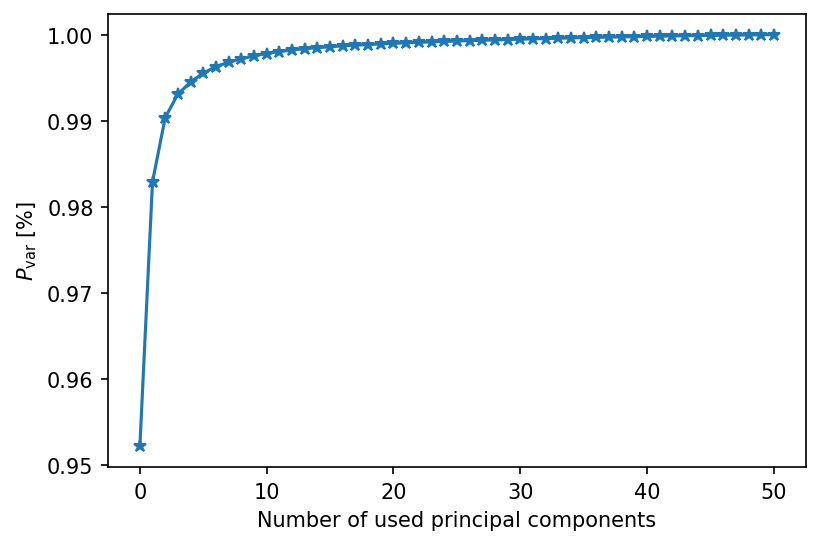

In [5]:
# Adjust the computation a bit
def compute_principal_components(X):
  X_mean = X.mean(axis=1)[:,np.newaxis]
  X_centered = X - X_mean
  C = np.cov(X_centered)
  V, E = np.linalg.eigh(C)

  # Sort the vectors based on the explained variance
  explained_variance = V / V.sum()
  sorting_indices = np.flip(np.argsort(explained_variance))
  E, V = E[:, sorting_indices], V[sorting_indices]

  return E, V, X_mean.squeeze()

# Vectorize the spectral image cube into a collection of spectrum vectors
# by reshaping the cube:
vector = spim2vec(cube)

pcs, eigenvalues, X_mean = compute_principal_components(vector)
print(f'Explained variances: {eigenvalues / eigenvalues.sum()}')
print(f'The indices: {np.flip(np.argsort(eigenvalues / eigenvalues.sum()))}')
print(f'Mean vector shape: {X_mean.shape}')

cumulative_explained_variance = np.cumsum(eigenvalues / eigenvalues.sum())

plt.figure(dpi=150)
plt.plot(np.arange(0, eigenvalues.shape[0]), cumulative_explained_variance, '-*');
plt.xlabel('Number of used principal components');
plt.ylabel('$P_\mathrm{var}$ [%]');


# Projecting spectral image cube to a new basis

Projected vector of shape (51, 1447680) reshaped into cube (1040, 1392, 51)


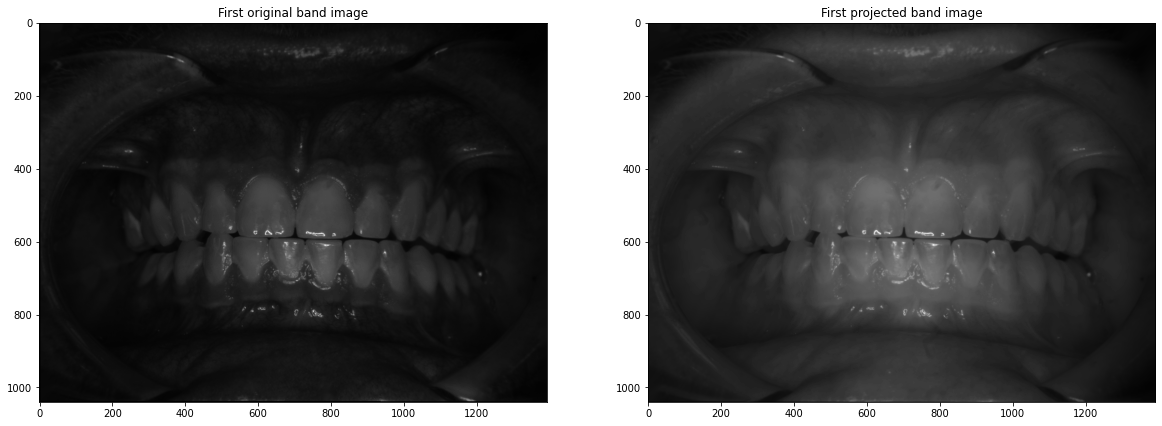

In [6]:
projected_vector = pcs.T @ vector
projected_cube = vec2spim(projected_vector, cube.shape)

print(f'Projected vector of shape {projected_vector.shape} reshaped into cube {projected_cube.shape}')

plt.figure(figsize=(20,15))
plt.subplot(1,2,1)
plt.imshow(cube[:,:,0], cmap='gray')
plt.title('First original band image');
plt.subplot(1,2,2)
plt.imshow(projected_cube[:,:,0], cmap='gray')
plt.title('First projected band image');

#for band in np.arange(0, projected_cube.shape[2]):
#  print(f'band {band} min {projected_cube[:,:,band].min()} max {projected_cube[:,:,band].max()}')


# Alternative principal component analysis implementation

## Principal component vectors

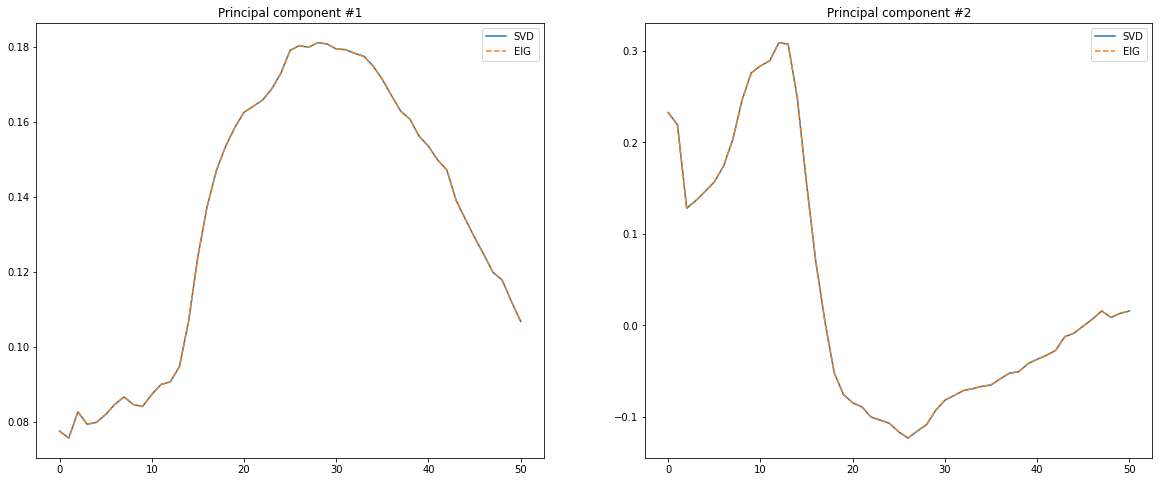

In [7]:
# Let's compare our implementation to the one provided by the scikit-learn package:
from sklearn.decomposition import PCA

pca_object = PCA()
pca_object.fit(vector.T)
svd_projected_vector = pca_object.transform(vector.T)
svd_projected_cube = vec2spim(svd_projected_vector.T, cube.shape)

plt.figure(figsize=(20, 8))
plt.subplot(1,2,1)
plt.plot(pca_object.components_[0, :], label='SVD')
plt.plot(pcs[:, 0], '--', label='EIG');
plt.title('Principal component #1');
plt.legend();

plt.subplot(1,2,2)
plt.plot(pca_object.components_[1, :], label='SVD')
plt.plot(pcs[:, 1], '--', label='EIG');
plt.title('Principal component #2');
plt.legend();


## Projected band images

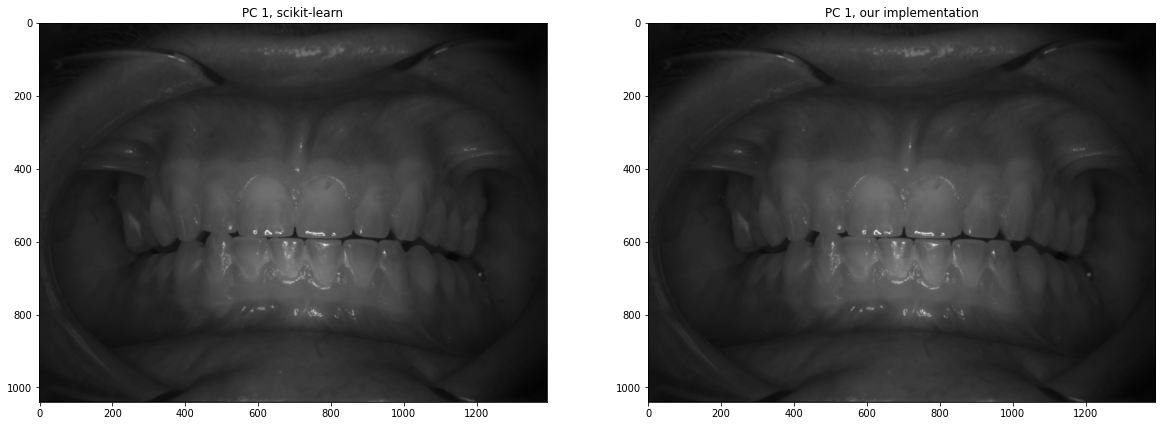

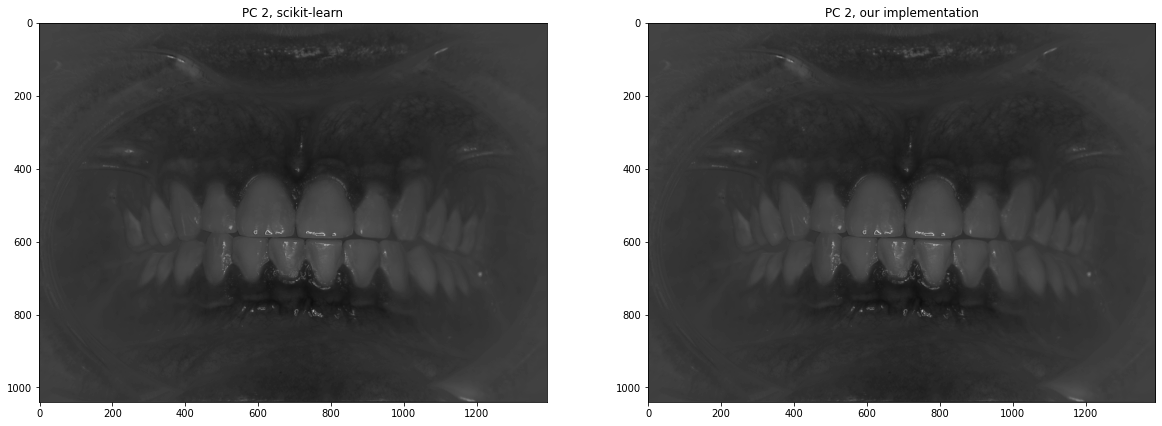

In [8]:
plt.figure(figsize=(20,15))
plt.subplot(1,2,1)
plt.imshow(svd_projected_cube[:,:,0], cmap='gray')
plt.title('PC 1, scikit-learn')
plt.subplot(1,2,2)
plt.imshow(projected_cube[:,:,0], cmap='gray')
plt.title('PC 1, our implementation');

plt.figure(figsize=(20,15))
plt.subplot(1,2,1)
plt.imshow(svd_projected_cube[:,:,1], cmap='gray')
plt.title('PC 2, scikit-learn')
plt.subplot(1,2,2)
plt.imshow(projected_cube[:,:,1], cmap='gray')
plt.title('PC 2, our implementation');

# Principal component analysis and image enhancement

## Data preparation

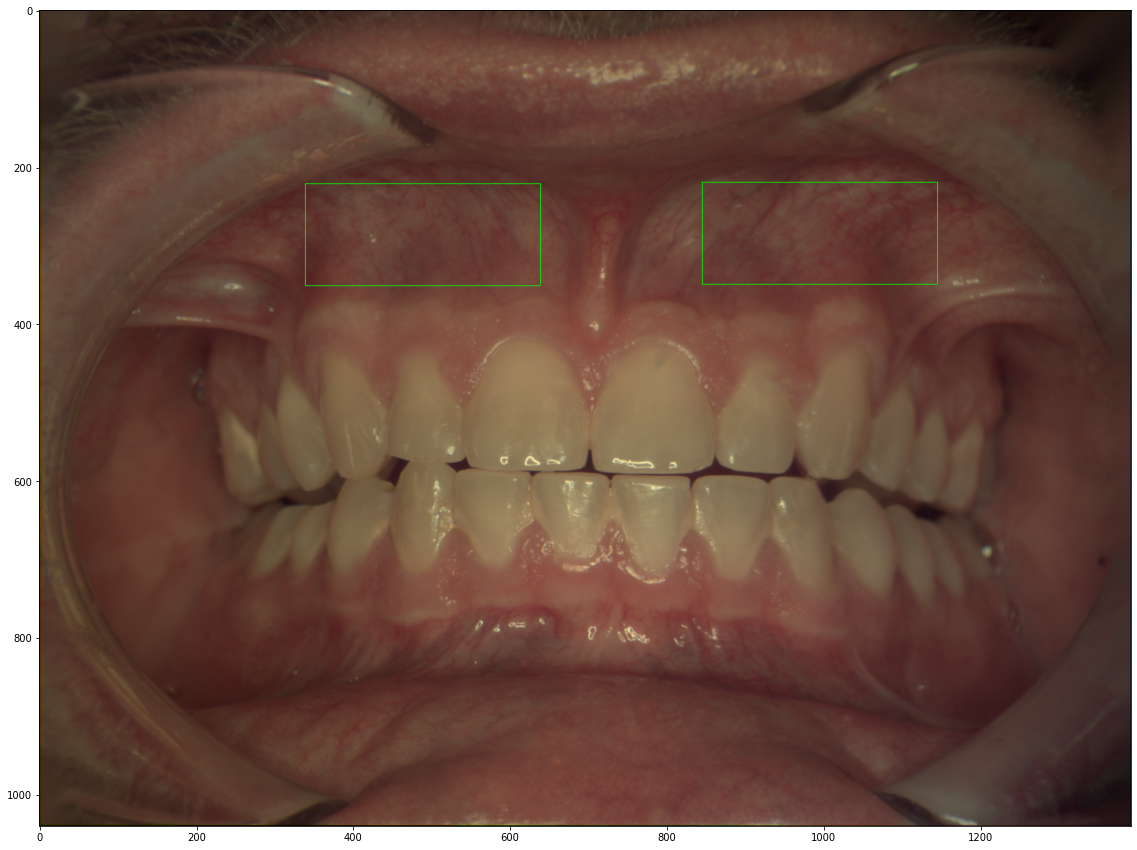

In [9]:
# Crop two areas on the blood vessel-y oral mucosa
pieces = [
          (339, 221, 300, 130),
          (845, 219, 300, 130),
]

# Create an annotated color image showing the selected areas
cropped_cubes = []
marked_visualization = color_image.copy()
for piece in pieces:
  # Draw a box
  x, y, w, h = piece
  marked_visualization[y, x:x + w, :] = [0, 255, 0]
  marked_visualization[y:y + h, x, :] = [0, 255, 0]
  marked_visualization[y:y + h, x + w, :] = [0, 255, 0]
  marked_visualization[y + h, x:x + w, :] = [0, 255, 0]

  # Extract the marked cube and store it in a list
  cropped_cubes.append(cube[y:y+h, x:x+w, :])

# Show the annotated color image
plt.figure(figsize=(20,15))
plt.imshow(marked_visualization);


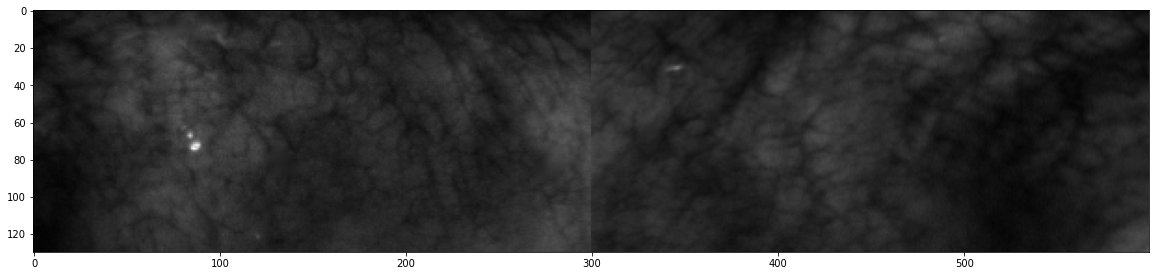

In [10]:
# Since the cropped areas are equal in size, combine them into a single
# numpy-array horizontally (hstack)
combi_cube = np.hstack(cropped_cubes)

# Show the first band image of the combined cube
plt.figure(figsize=(20,15))
plt.imshow(combi_cube[:,:,0], cmap='gray');


## Principal component analysis, data exploration and projection

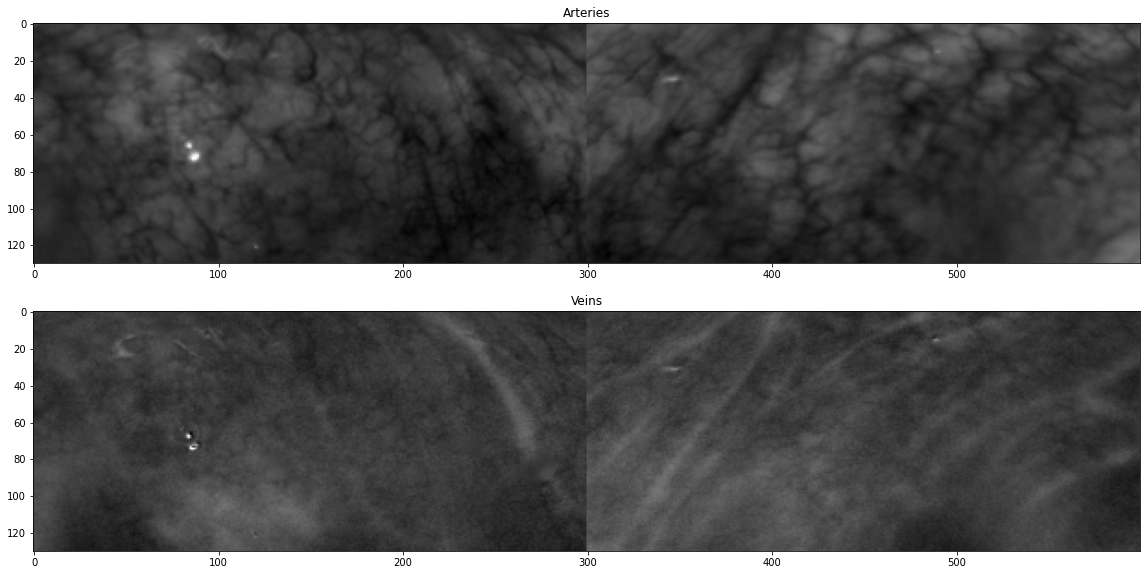

In [11]:
combi_vector = spim2vec(combi_cube)
combi_vector_pca = PCA()
combi_vector_pca.fit(combi_vector.T)
projected_combi_vector = combi_vector_pca.transform(combi_vector.T)
projected_combi_cube = vec2spim(projected_combi_vector.T, combi_cube.shape)

artery_component_index = 2
vein_component_index = 4

artery_combi_image = projected_combi_cube[:,:,artery_component_index]
vein_combi_image = projected_combi_cube[:,:,vein_component_index]

plt.figure(figsize=(20,15))
plt.subplot(3,1,1)
plt.imshow(artery_combi_image, cmap='gray')
plt.title('Arteries');

plt.subplot(3,1,2)
plt.imshow(vein_combi_image, cmap='gray')
plt.title('Veins');

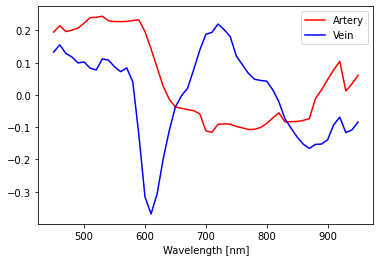

In [12]:
plt.figure()
plt.plot(wavelengths, combi_vector_pca.components_[artery_component_index, :], 'r', label='Artery')
plt.plot(wavelengths, combi_vector_pca.components_[vein_component_index, :], 'b', label='Vein')
plt.legend();
plt.xlabel('Wavelength [nm]');

## Full projection and final adjustements



### Full projection

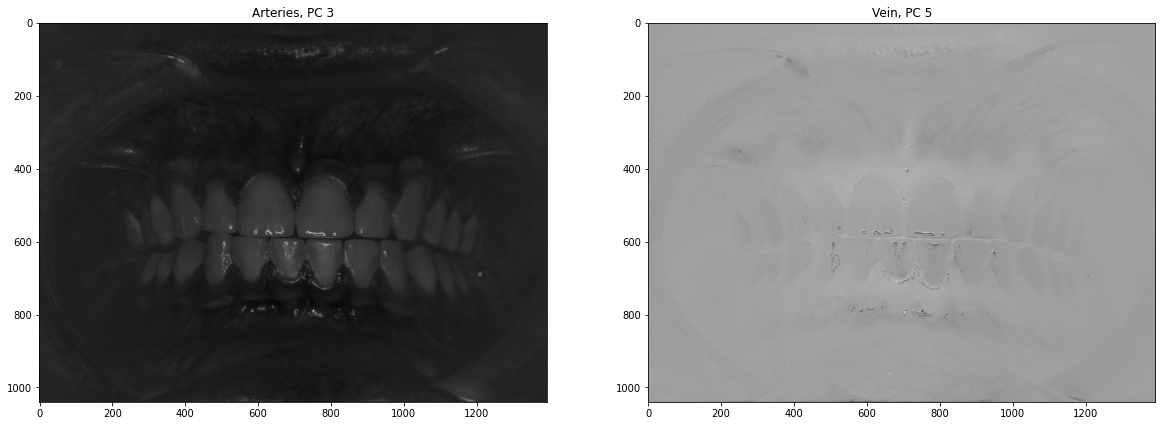

In [13]:
projected_cube = vec2spim(combi_vector_pca.transform(spim2vec(cube).T).T, cube.shape)
artery_image = projected_cube[:,:, artery_component_index]
vein_image = projected_cube[:,:, vein_component_index]

plt.figure(figsize=(20, 15))
plt.subplot(1,2,1)
plt.imshow(artery_image, cmap='gray');
plt.title(f'Arteries, PC {artery_component_index+1}');
plt.subplot(1,2,2)
plt.imshow(invert(vein_image), cmap='gray');
plt.title(f'Vein, PC {vein_component_index+1}');

### Histogram clipping

Artery image pixel brightness range: -0.205 -- 1.958
Vein image pixel brightness range  : -0.383 -- 0.605

New artery image pixel brightness range: -0.100 -- 0.408
New vein image pixel brightness range  : -0.065 -- 0.035


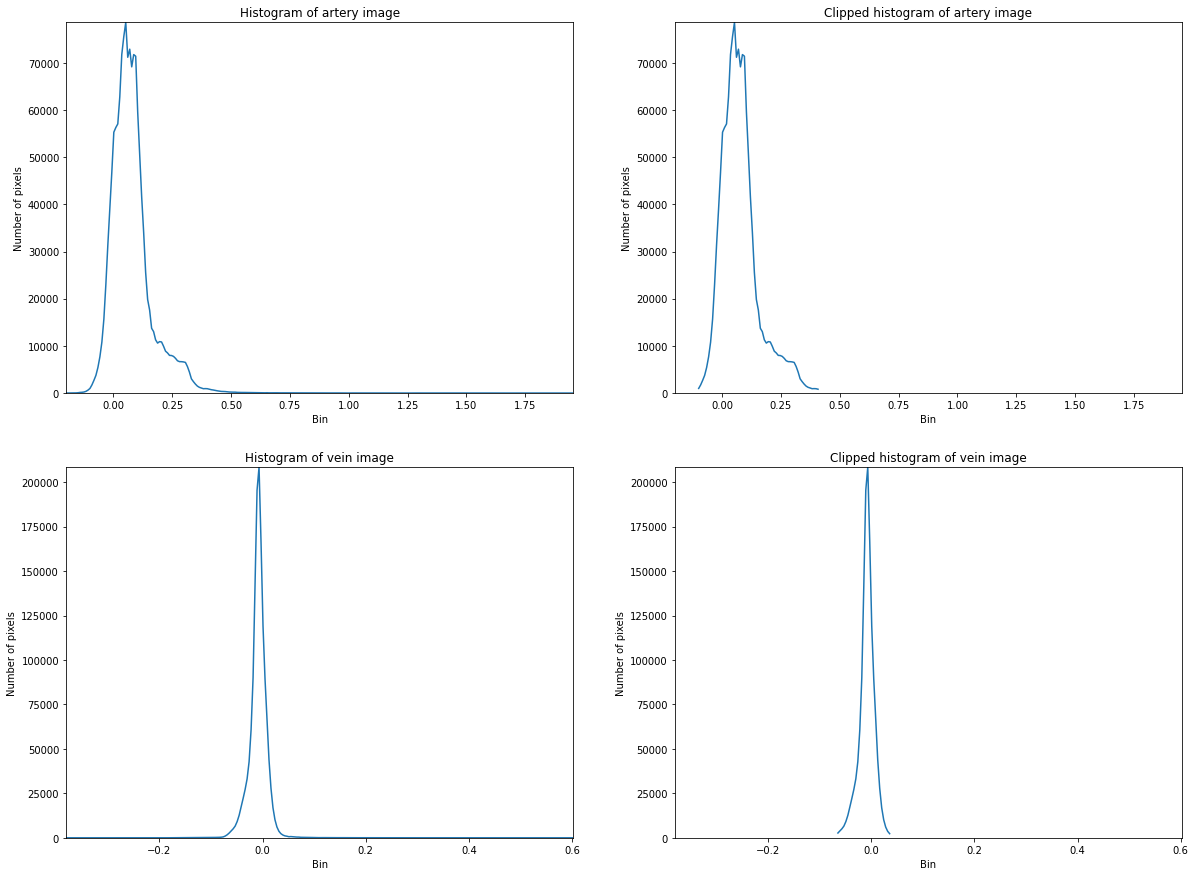

In [14]:
artery_histogram_cutoff = 1.0
artery_hist, artery_hist_centers = histogram(artery_image)
artery_hist_cutoff = (artery_hist / artery_hist.max() * 100) > artery_histogram_cutoff
artery_relevant_hist_centers = artery_hist_centers[artery_hist_cutoff]
artery_in_range = (artery_relevant_hist_centers.min(), artery_relevant_hist_centers.max())

vein_histogram_cutoff = 1.0
vein_hist, vein_hist_centers = histogram(vein_image)
vein_hist_cutoff = (vein_hist / vein_hist.max() * 100) > vein_histogram_cutoff
vein_relevant_hist_centers = vein_hist_centers[vein_hist_cutoff]
vein_in_range = (vein_relevant_hist_centers.min(), vein_relevant_hist_centers.max())

print(f'Artery image pixel brightness range: {artery_image.min():0.3f} -- {artery_image.max():0.3f}')
print(f'Vein image pixel brightness range  : {vein_image.min():0.3f} -- {vein_image.max():0.3f}')
print()
print(f'New artery image pixel brightness range: {artery_in_range[0]:0.3f} -- {artery_in_range[1]:0.3f}')
print(f'New vein image pixel brightness range  : {vein_in_range[0]:0.3f} -- {vein_in_range[1]:0.3f}')

plt.figure(figsize=(20, 15))
plt.subplot(2,2,1)
plt.plot(artery_hist_centers, artery_hist);
plt.axis([artery_hist_centers.min(), artery_hist_centers.max(), artery_hist.min(), artery_hist.max()]);
plt.title('Histogram of artery image');
plt.xlabel('Bin');
plt.ylabel('Number of pixels');

plt.subplot(2,2,2)
plt.plot(artery_relevant_hist_centers, artery_hist[artery_hist_cutoff]);
plt.axis([artery_hist_centers.min(), artery_hist_centers.max(), artery_hist.min(), artery_hist.max()]);
plt.title('Clipped histogram of artery image');
plt.xlabel('Bin');
plt.ylabel('Number of pixels');

plt.subplot(2,2,3)
plt.plot(vein_hist_centers, vein_hist);
plt.axis([vein_hist_centers.min(), vein_hist_centers.max(), vein_hist.min(), vein_hist.max()]);
plt.title('Histogram of vein image');
plt.xlabel('Bin');
plt.ylabel('Number of pixels');

plt.subplot(2,2,4)
plt.plot(vein_relevant_hist_centers, vein_hist[vein_hist_cutoff]);
plt.axis([vein_hist_centers.min(), vein_hist_centers.max(), vein_hist.min(), vein_hist.max()]);
plt.title('Clipped histogram of vein image');
plt.xlabel('Bin');
plt.ylabel('Number of pixels');


### Rescaling

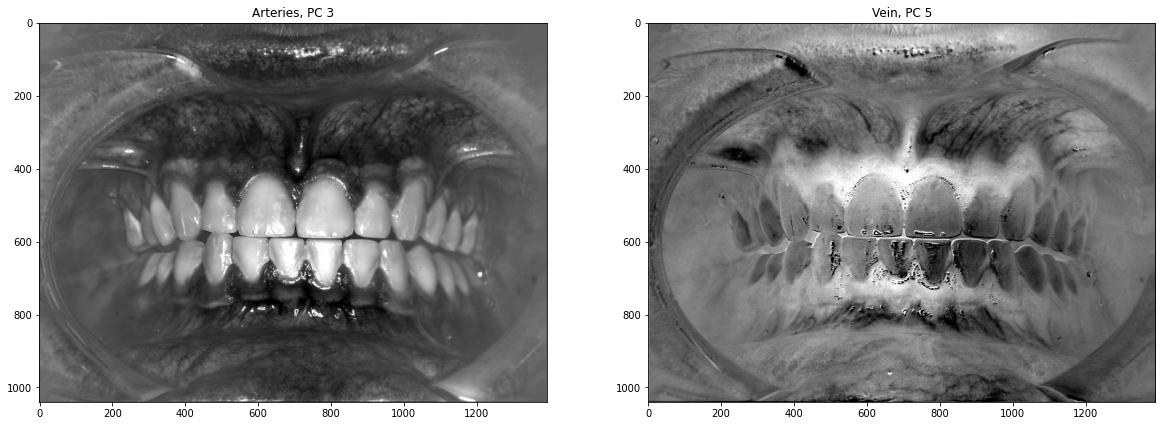

In [15]:
corrected_artery_image = rescale_intensity(artery_image, in_range=artery_in_range)
corrected_vein_image = rescale_intensity(vein_image, in_range=vein_in_range)

plt.figure(figsize=(20, 15))
plt.subplot(1,2,1)
plt.imshow(corrected_artery_image, cmap='gray')
plt.title(f'Arteries, PC {artery_component_index+1}');

plt.subplot(1,2,2)
plt.imshow(invert(corrected_vein_image), cmap='gray')
plt.title(f'Vein, PC {vein_component_index+1}');
